In [1]:
#  Load Data from Local Storage (For Colab)
from google.colab import files
uploaded = files.upload()

Saving insurance_claims.csv to insurance_claims.csv


In [12]:
# Read the CSV file (Replace 'insurance_claims.csv' with your actual filename)
filename = list(uploaded.keys())[0]  # Get uploaded file name dynamically
df = pd.read_csv(filename)

In [13]:

# Step 2: Display Basic Info About the Data
print("Dataset Overview:")
print(df.info())
print("\nMissing Values Per Column:\n", df.isnull().sum())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  i

Model Accuracy: 0.8100

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.89      0.88       151
           1       0.62      0.57      0.60        49

    accuracy                           0.81       200
   macro avg       0.74      0.73      0.74       200
weighted avg       0.81      0.81      0.81       200



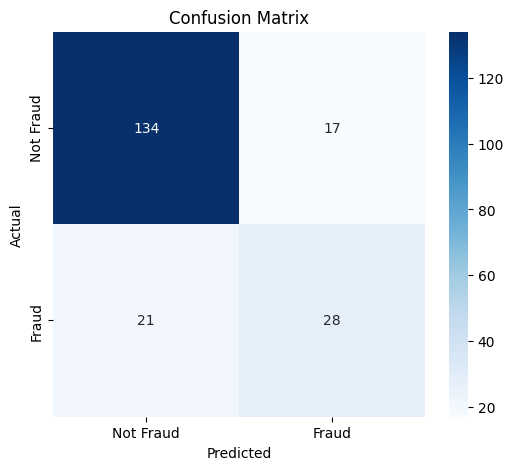

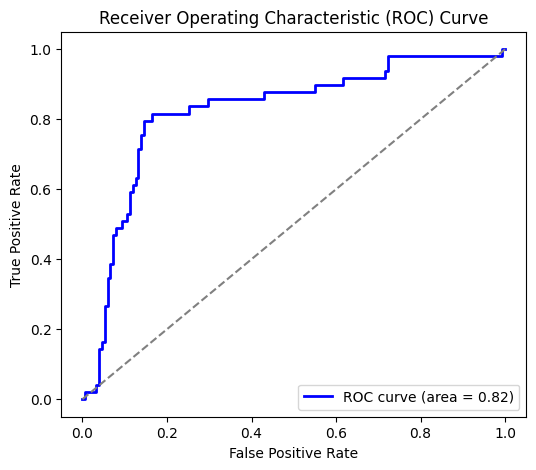

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from scipy.stats import zscore

# Load dataset
df = pd.read_csv("/content/insurance_claims.csv")

# Preprocessing function
def preprocess_insurance_data(df):
    df.replace('?', np.nan, inplace=True)  # Replace '?' with NaN
    df['fraud_reported'] = df['fraud_reported'].map({'Y': 1, 'N': 0})  # Convert to binary

    # Convert date columns
    df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'], errors='coerce')
    df['incident_date'] = pd.to_datetime(df['incident_date'], errors='coerce')

    # Drop unnecessary columns
    drop_columns = ['policy_number', 'insured_zip', 'incident_location', 'auto_make', 'auto_model']
    df.drop(columns=drop_columns, inplace=True, errors='ignore')

    # Handle missing categorical values
    categorical_cols = df.select_dtypes(include=['object']).columns
    df[categorical_cols] = df[categorical_cols].fillna('Unknown')

    # One-hot encoding
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    return df

# Outlier Handling (Capping extreme values)
def cap_outliers(df, threshold=3.0):
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    numerical_cols.remove("fraud_reported")  # Exclude target

    for col in numerical_cols:
        upper_bound = df[col].mean() + threshold * df[col].std()
        lower_bound = df[col].mean() - threshold * df[col].std()
        df[col] = df[col].clip(lower_bound, upper_bound)

    return df

# Standardization
def standardize_data(df):
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    numerical_cols.remove("fraud_reported")  # Exclude target

    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    return df

# Apply preprocessing
df_cleaned = preprocess_insurance_data(df)
df_capped = cap_outliers(df_cleaned)
df_standardized = standardize_data(df_capped)

# Drop datetime columns
datetime_cols = ["policy_bind_date", "incident_date"]
df_standardized.drop(columns=datetime_cols, errors="ignore", inplace=True)

# Split data
X = df_standardized.drop(columns=["fraud_reported"])
y = df_standardized["fraud_reported"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train SVM with Linear Kernel
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Predictions & Evaluation
y_pred = svm_model.predict(X_test)
y_prob = svm_model.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)

# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()
